# Analyzing Rat snATAC-seq

## Setup

Get the paths to the files and set our working directory.

In [1]:
sample = "data/10x/Rat_Amygdala_cocaine_low/outs"

# Files from CellRanger:
# 1) peak/cell matrix - counts of the Tn5 cut sites within each peak
raw = paste0(sample, "/filtered_peak_bc_matrix.h5")
# 2) some metadata
metadata = paste0(sample, "/singlecell.csv")
# 3) a list of unique fragments across all single cells
fragments = paste0(sample, "/fragments.tsv.gz")

In [2]:
# change to the data/.. dir
setwd("..")

In [3]:
# set the plot sizes to be full width
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

Load our dependencies.

Note that this notebook is being run from within a conda environment. You can use our `env.yml` file to reproduce it.

In [4]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
suppressMessages(library(EnsDb.Rnorvegicus.v79))
# suppressMessages(library(BSgenome.Rnorvegicus.UCSC.rn6))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))

In [5]:
counts = Read10X_h5(filename = raw)
metadata = read.csv(
  file = metadata,
  header = TRUE,
  row.names = 1
)

In [6]:
amygdala = CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject.default(counts = counts, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix"


In [7]:
fragment.path = fragments
amygdala = SetFragments(
  object = amygdala,
  file = fragment.path
)

## Computing QC Metrics

In [8]:
# note we currently only do this for chr1 because it can take a while
# in the future, you should do this for the entire genome
amygdala <- NucleosomeSignal(object = amygdala, region = "1-1-249250621")

Extracting reads in requested region

Computing ratio of mononucleosomal to nucleosome-free fragments



Next, we calculate the following quality control metrics:
1. `nucleosome_signal` - the approximate ratio of mononucleosomal fragments (147 bp < len < 294 bp) to nucleosome-free fragments (len < 147 bp) for each cell
    - Good cells will have low numbers (less than ~10)
2. `TSS.enrichment` - the ratio of fragments centered at the TSS to fragments in TSS-flanking regions
    - Good cells will have high TSS enrichment scores (> 2)
3. `peak_region_fragments` - total number of fragments in peaks
    - Good cells won't be too high or too low here
    - Low numbers represent cells with low sequencing depth and high numbers represent doublets or nuclear clumps
4. `pct_reads_in_peaks` - fraction of fragments in peaks
    - Good cells will have high values (> 15-20%)

Note that we don't calculate the ratio of reads in blacklist sites because ENCODE hasn't done this for rats yet.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 14 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 14 rows containing missing values (geom_point)."
Warning message:
"Removed 215 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 200 rows containing missing values (geom_point)."


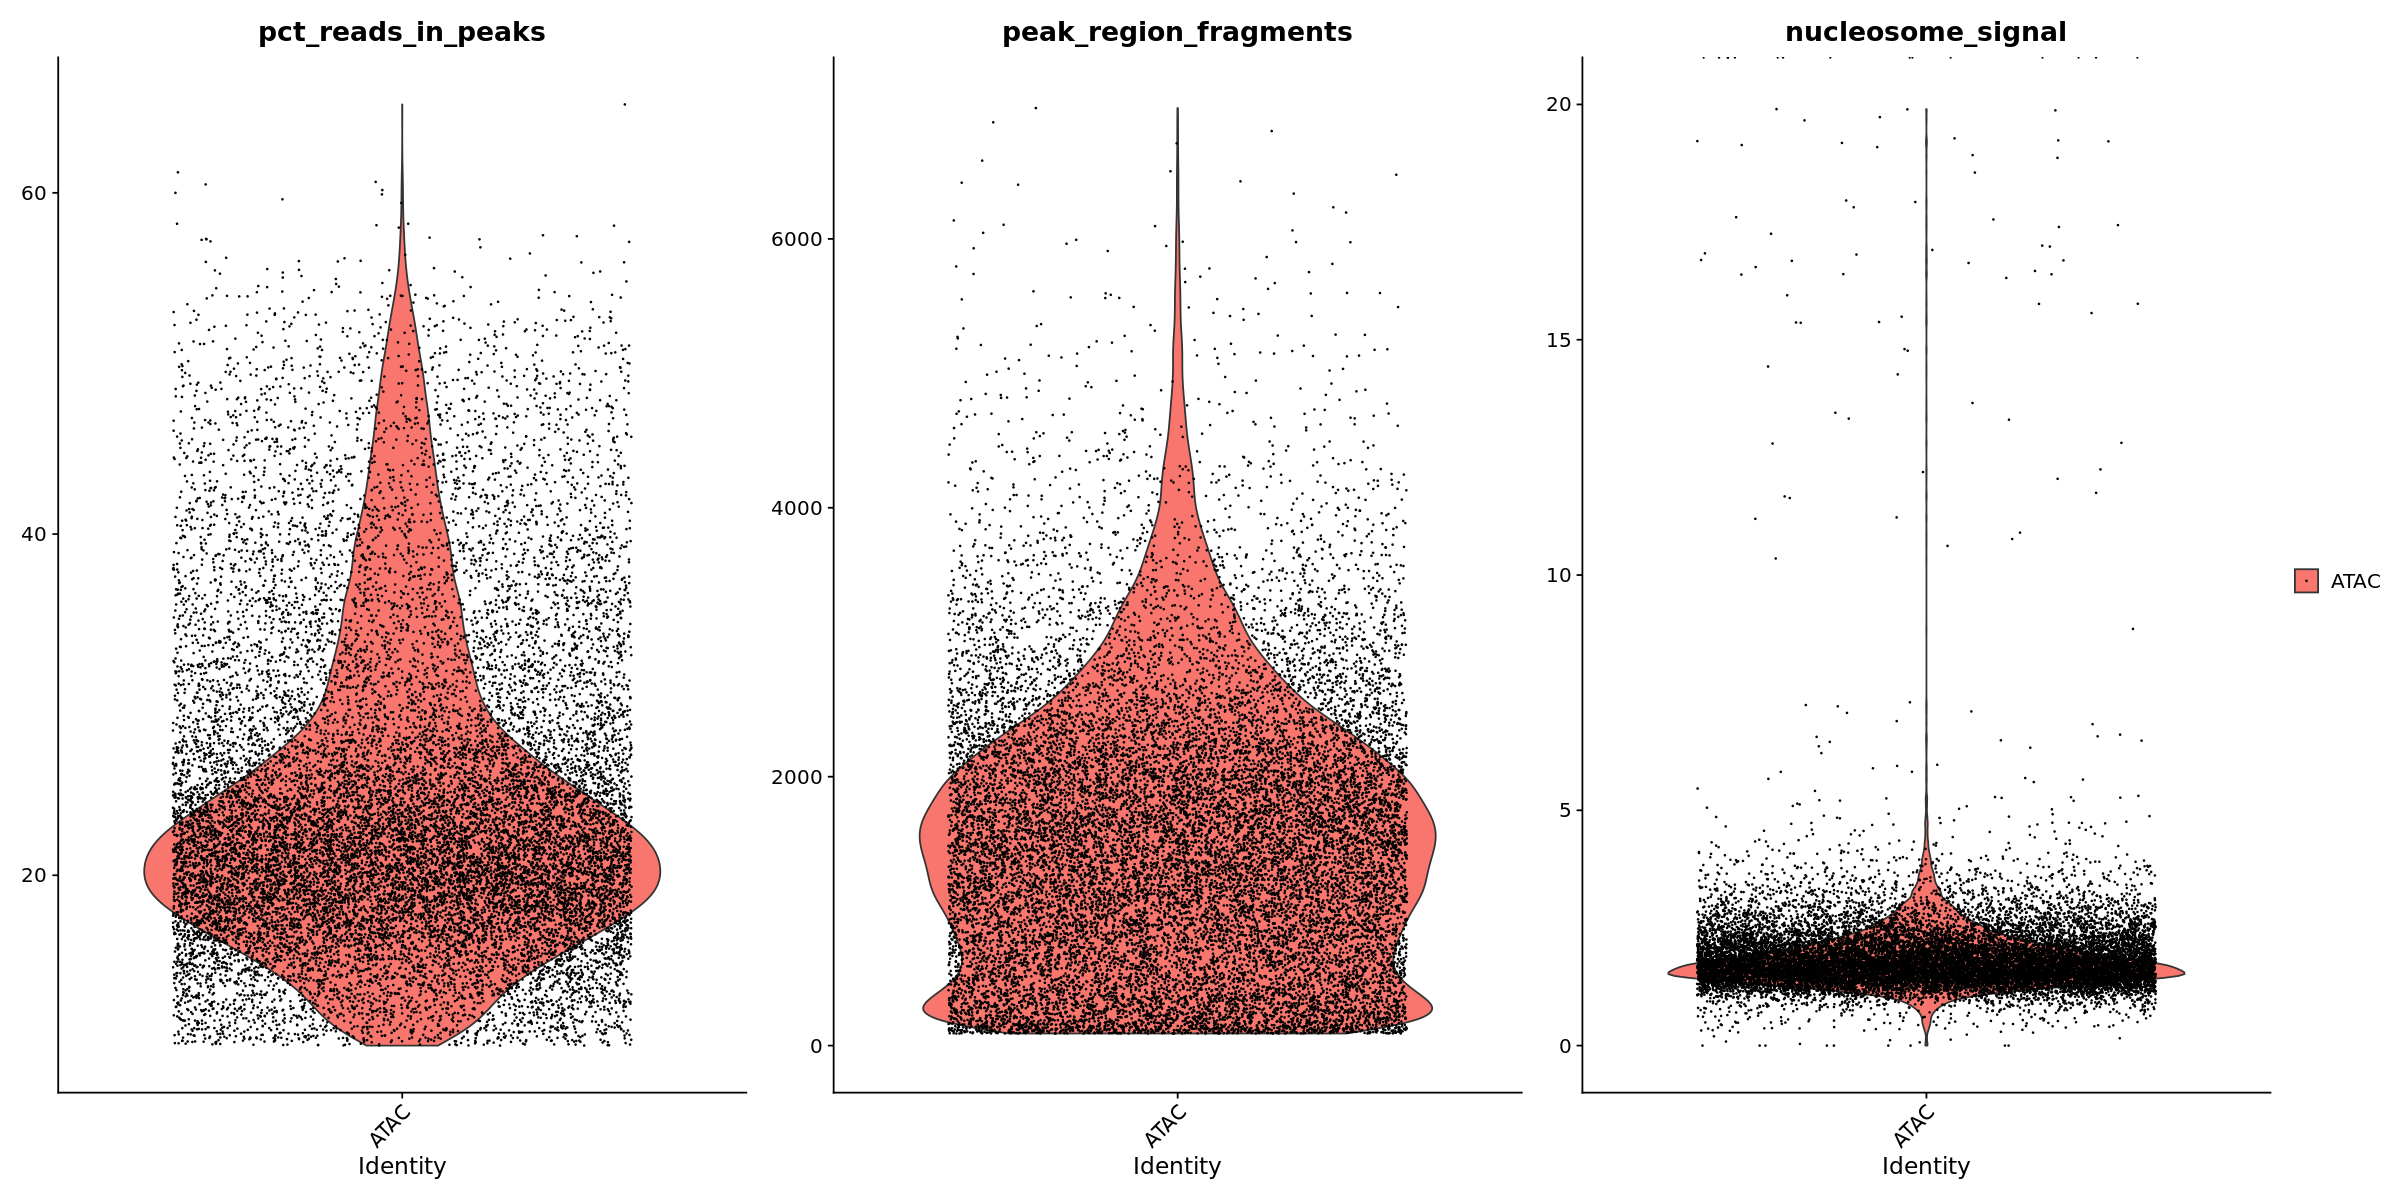

In [9]:
amygdala$pct_reads_in_peaks <- amygdala$peak_region_fragments / amygdala$passed_filters * 100

p1 <- VlnPlot(amygdala, c('pct_reads_in_peaks'), pt.size = 0.1) + NoLegend()
p2 <- VlnPlot(amygdala, c('peak_region_fragments'), pt.size = 0.1) + NoLegend() + ylim(0, 7000)
p3 <- (VlnPlot(amygdala, c('nucleosome_signal'), pt.size = 0.1) & scale_y_log10()) + ylim(0, 20)

p1 | p2 | p3

Let's get rid of cells with a high `nucleosome_signal` and plot the histogram of fragments for the others.

Warning message:
"Removed 97 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 4 rows containing missing values (geom_bar)."


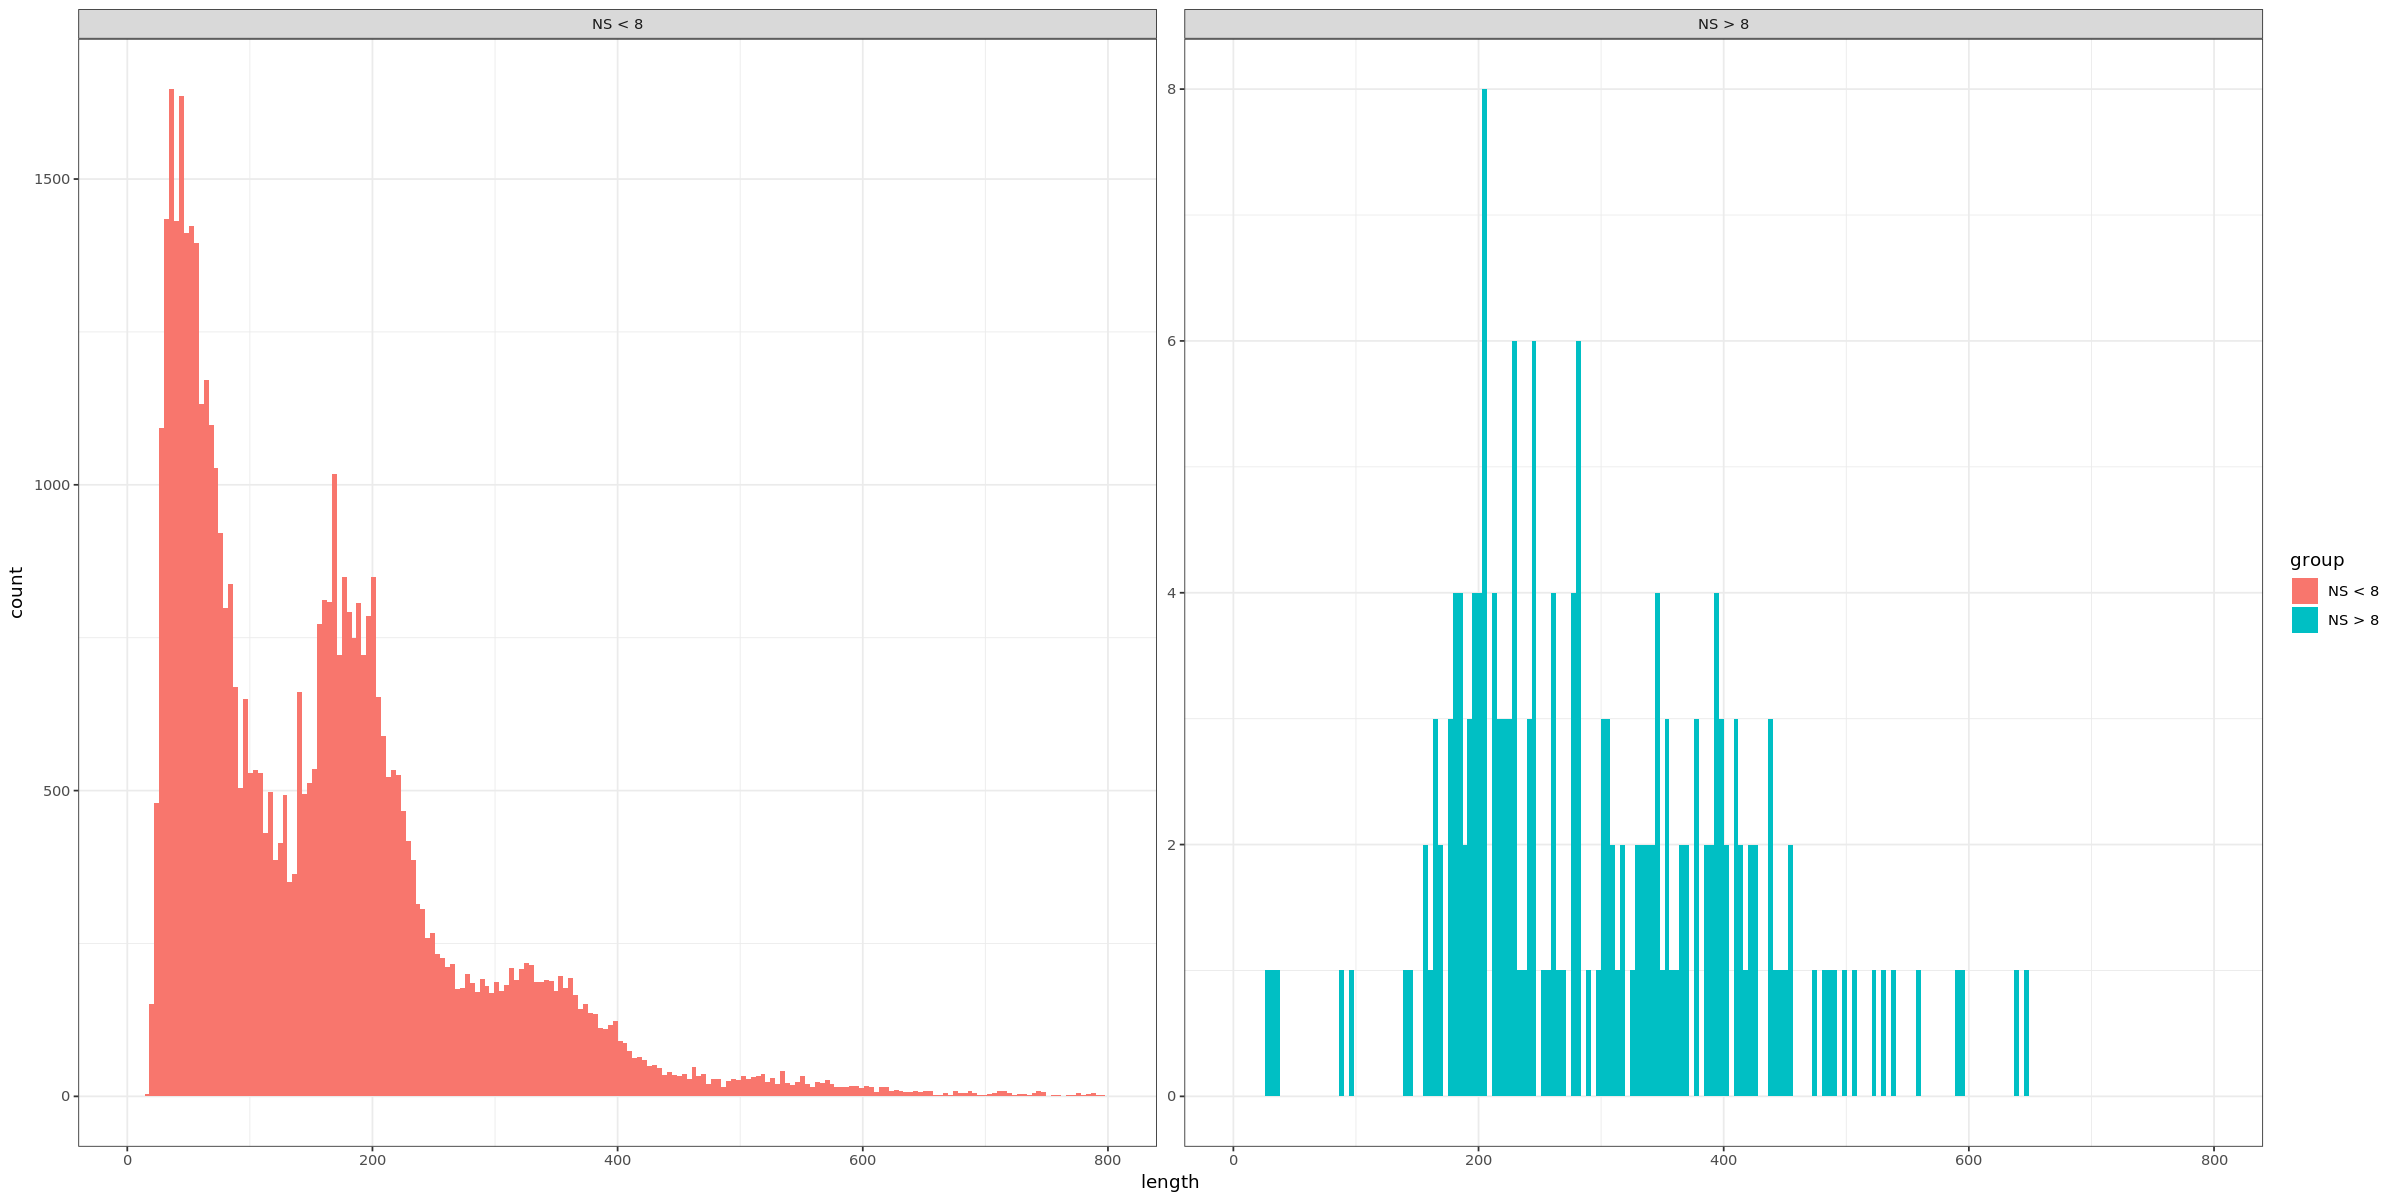

In [10]:
amygdala$nucleosome_group <- ifelse(amygdala$nucleosome_signal > 8, 'NS > 8', 'NS < 8')
# TODO: change the region from chr1 to something more useful
FragmentHistogram(object = amygdala, group.by = 'nucleosome_group', region='1-1-2000000')

Now, we can calculate the TSS enrichment score for each cell.

In [11]:
# create granges object with TSS positions
# not sure which reference genome is the right one to use here, but I chose Rnorvegicus
# we grab the TSS positions from the reference genome
gene.ranges <- genes(EnsDb.Rnorvegicus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]
gene.ranges <- keepStandardChromosomes(gene.ranges, pruning.mode = 'coarse')

tss.ranges <- resize(gene.ranges, width = 1, fix = "start")
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 4000 TSSs
amygdala <- TSSEnrichment(object = amygdala, tss.positions = tss.ranges[1:4000])

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



Our TSS scores are low. We would expect scores near the TSS to be greater than 5 (ideally, around 10). For bulk ATAC-seq, the ENCODE project lists scores less than 5 as ["concerning"](https://www.encodeproject.org/atac-seq/).

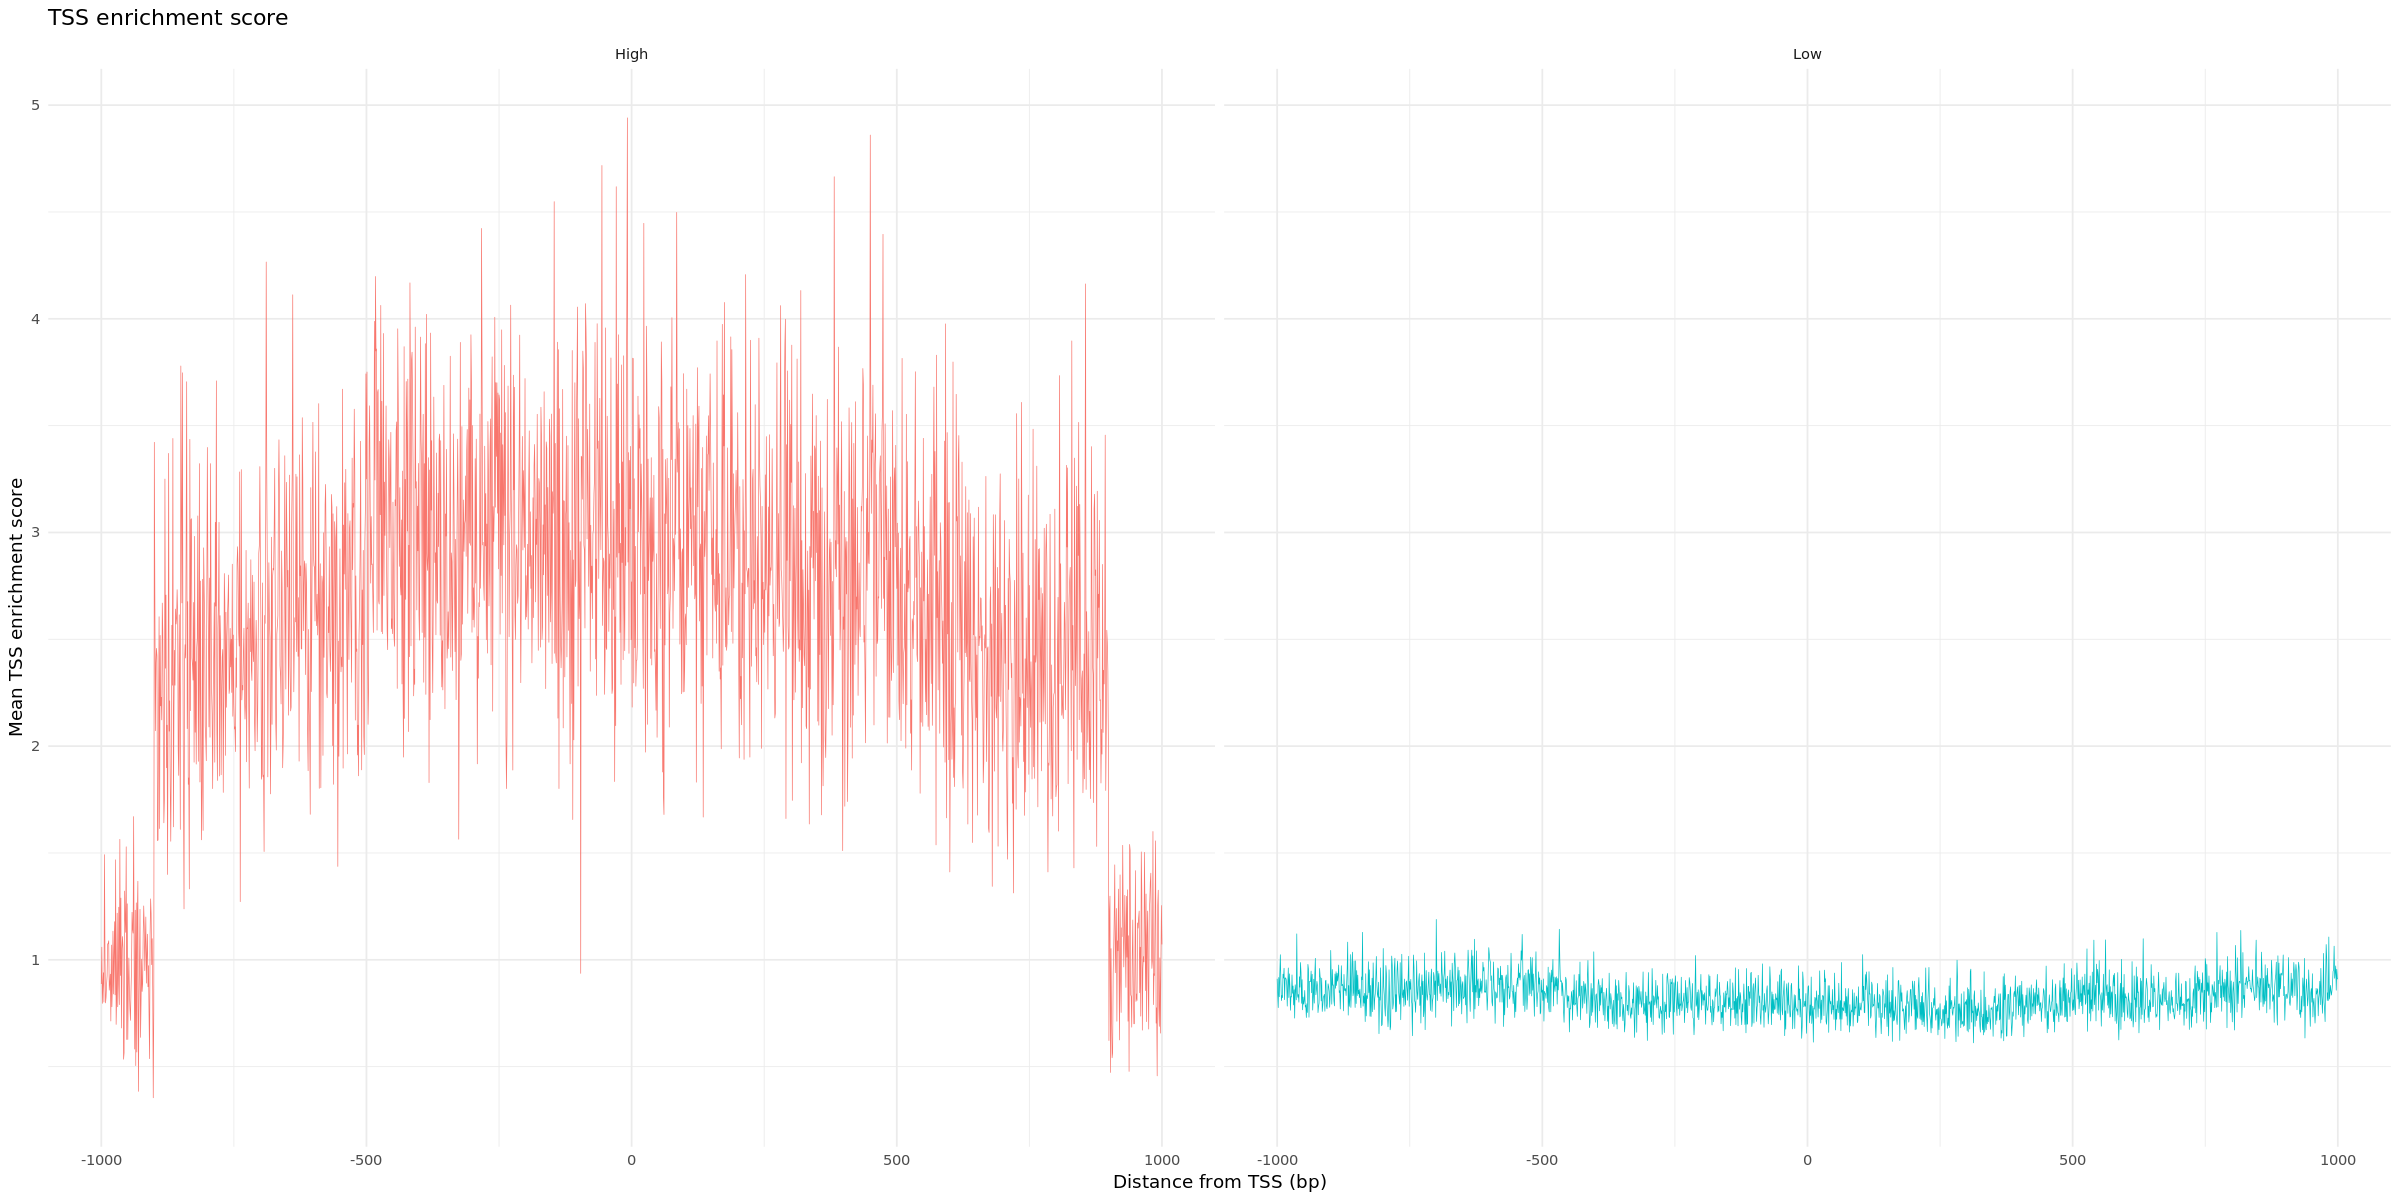

In [12]:
amygdala$high.tss <- ifelse(amygdala$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(amygdala, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

Now, we use our analysis to choose some cutoff values for the QC metrics.

In [13]:
amygdala <- subset(
  x = amygdala,
  subset = peak_region_fragments > 600 &
    peak_region_fragments < 6000 &
    pct_reads_in_peaks > 10 &
    nucleosome_signal < 8 &
    TSS.enrichment > 2
)
amygdala

An object of class Seurat 
65900 features across 1563 samples within 1 assay 
Active assay: peaks (65900 features, 0 variable features)

## Normalization and linear dimensional reduction

In [14]:
amygdala <- RunTFIDF(amygdala)
amygdala <- FindTopFeatures(amygdala, min.cutoff = 'q0')
amygdala <- RunSVD(
  object = amygdala,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



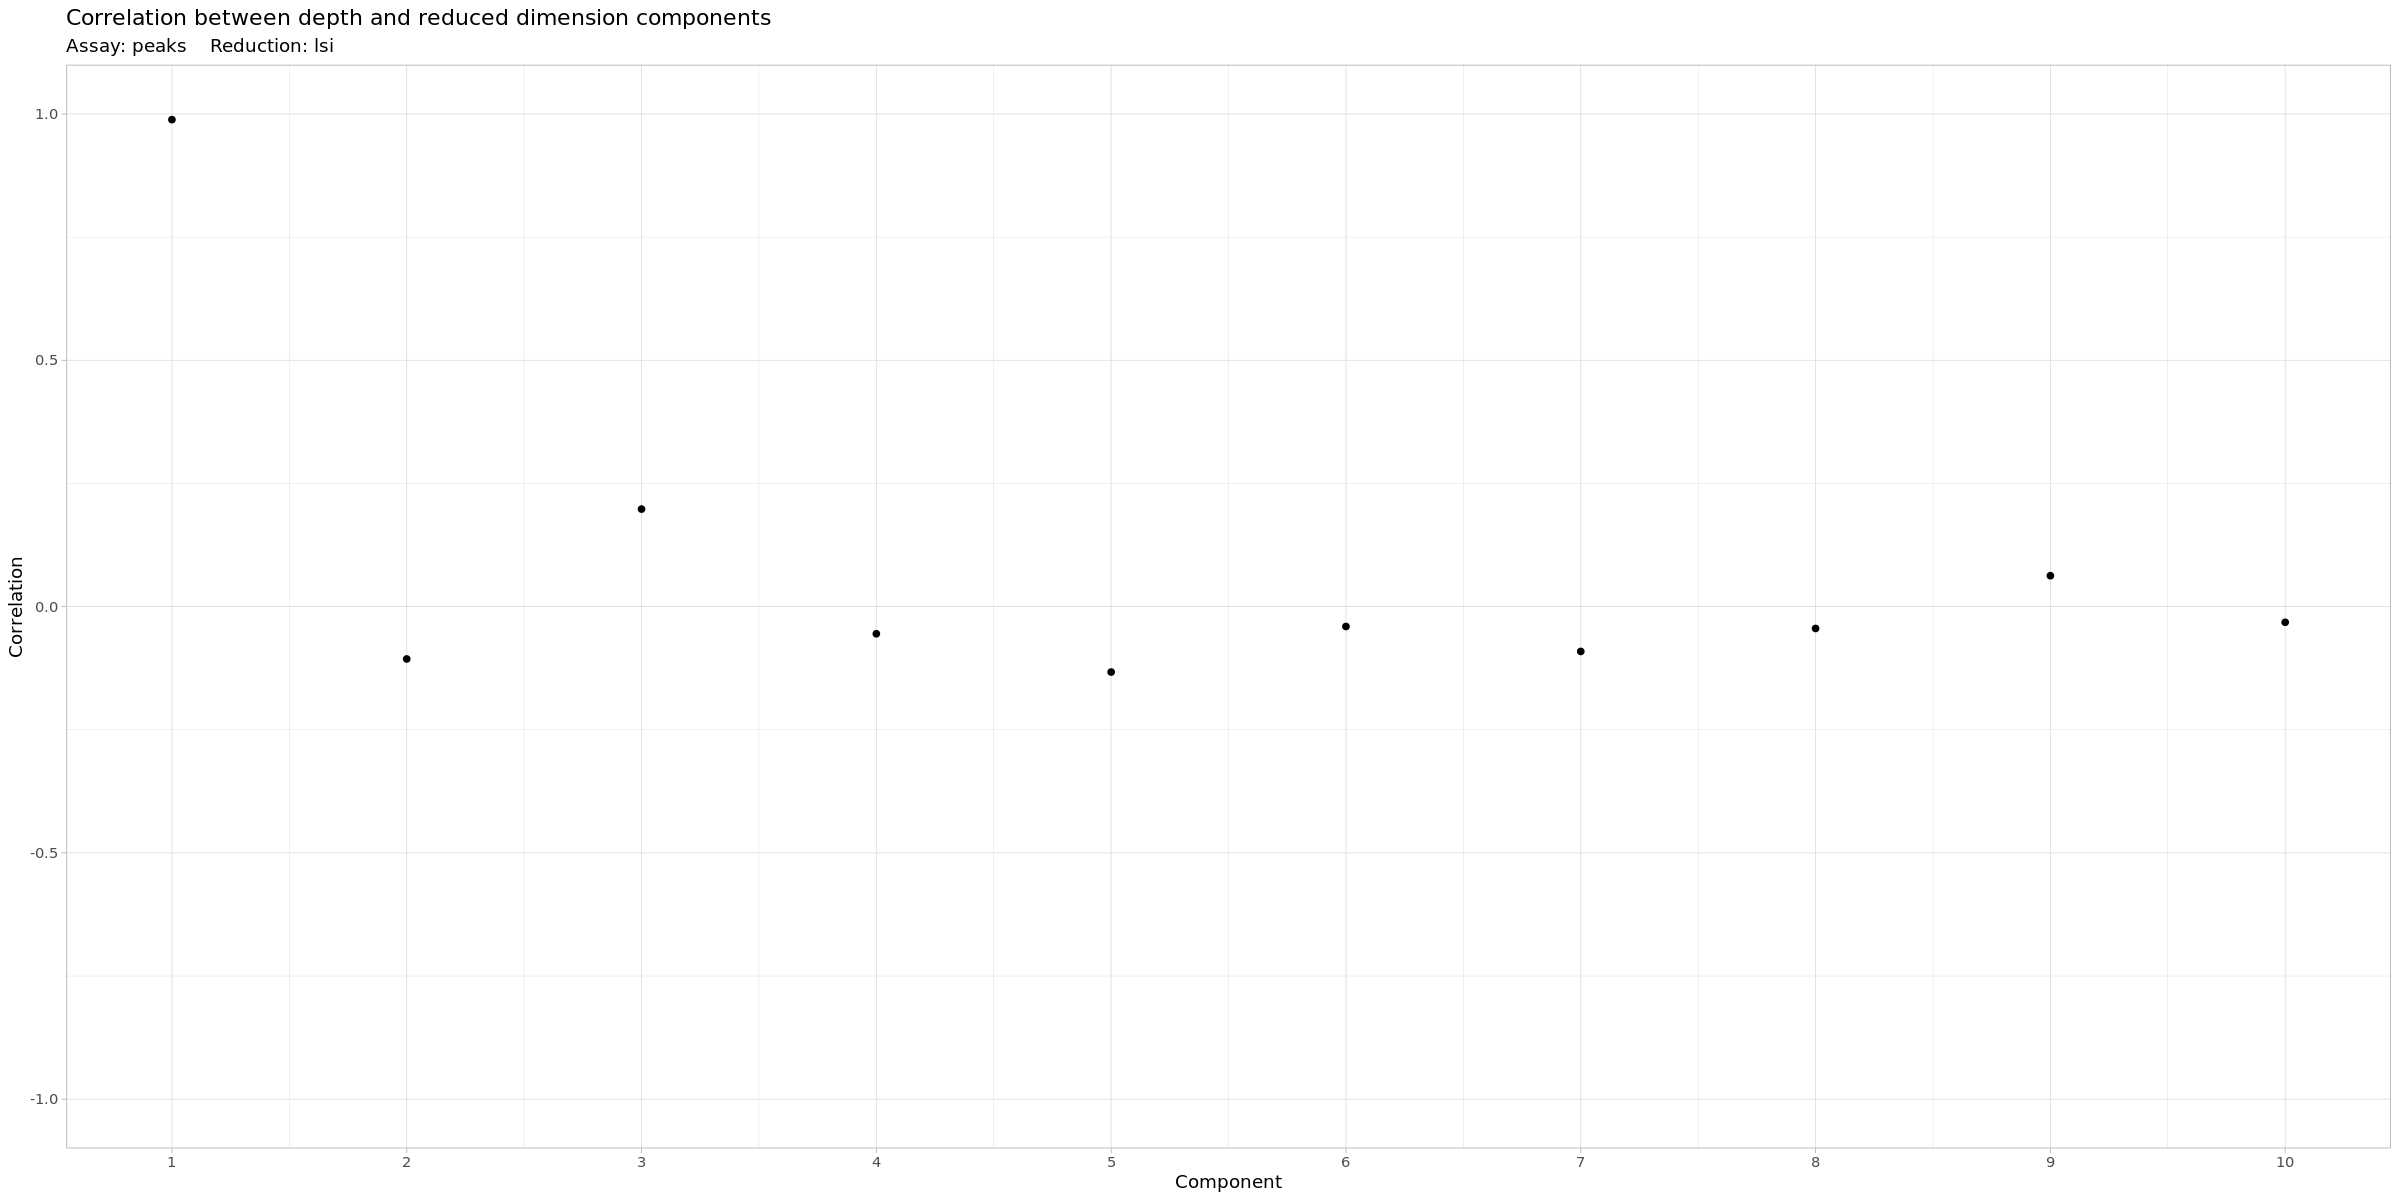

In [15]:
DepthCor(amygdala)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
08:11:33 UMAP embedding parameters a = 0.9922 b = 1.112

08:11:33 Read 1563 rows and found 29 numeric columns

08:11:33 Using Annoy for neighbor search, n_neighbors = 30

08:11:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

08:11:33 Writing NN index file to temp file /tmp/RtmpYvBmGw/file821c2cb59c

08:11:33 Searching Annoy index using 1 thread, search_k = 3000

08:11:33 Annoy recall = 100%

08:11:35 Commencing smooth kNN distance calibration using 1 thread

08:11:37 Initializing from

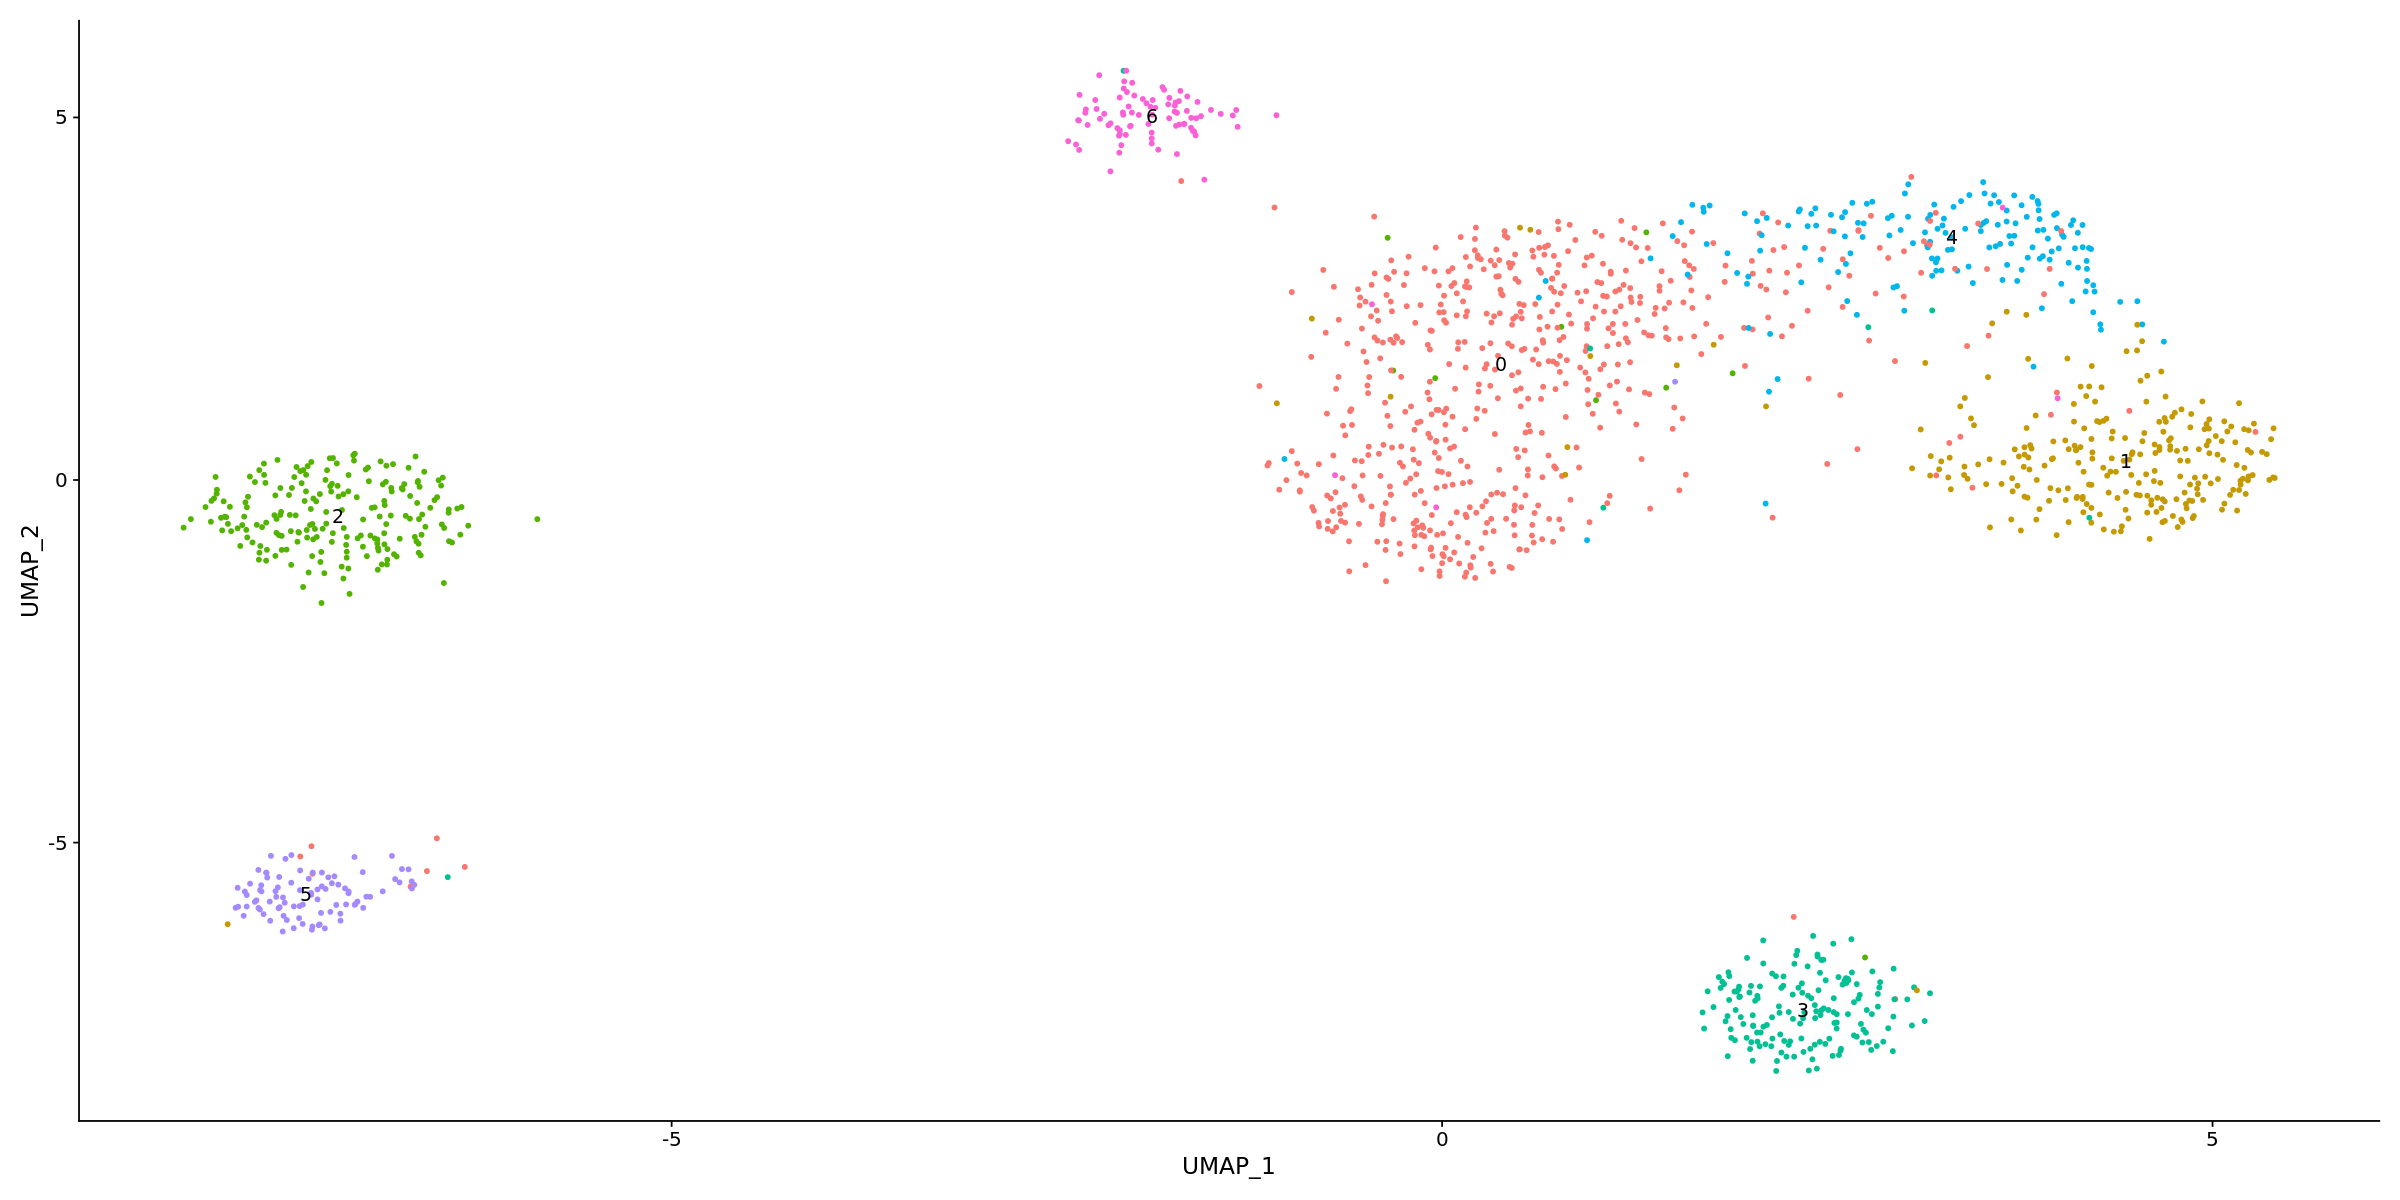

In [16]:
amygdala <- RunUMAP(object = amygdala, reduction = 'lsi', dims = 2:30)
amygdala <- FindNeighbors(object = amygdala, reduction = 'lsi', dims = 2:30)
amygdala <- FindClusters(object = amygdala, verbose = FALSE, algorithm = 3)
DimPlot(object = amygdala, label = TRUE) + NoLegend()